# Estimating the SCC using CIL damage functions and the FAIR SCM

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020 (updated from 2015)
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

Note: Damage function units fed into this calculation should be billions of 2019 USD

## Set up workspace

In [337]:
# Change this input file to your DB root!
DB = '/mnt/CIL_energy/code_release_data_pixel_interaction'
root =  "/home/liruixue/repos/energy-code-release-2020"

# Scenario options
model = 'main' # options are 'main', 'lininter', and 'lininter_double', 'lininter_half'
ssp = '1' # 2,3 or 4.Must by 3 if you are not running the main model 
hold_2100_damages_fixed = True # False or True 

# Toggle to generate plots or not
generate_plots = True

In [338]:
%matplotlib inline

In [339]:
# SSP must be "3" unless you are running the main model, in which case it can be 
# also 2 or 4. This is just due to the scenarios we choose to put in the paper. 

if model == 'lininter' or model == 'lininter_double' or model == 'lininter_half':
    assert ssp == '3',"ssp must be 3 unless you are running the main model"


In [340]:
! pip install fair==1.3.2

In [341]:
import numpy as np
import pandas as pd
import xarray as xr
import os, glob

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

In [342]:
# Assign price scenarios to run with

if ssp == '3':
    if model == 'lininter' or model == 'lininter_double' or model == 'lininter_half':
        # For lininter model:, or lininter_double or lininter_half model 
        scenario_to_run = 'price014' 
    else:
        # For main model
        scenario_to_run = 'price014', 'price0', 'price03', 'WITCHGLOBIOM42', 'MERGEETL60', 'REMINDMAgPIE1730', 'REMIND17CEMICS', 'REMIND17'
else:
    scenario_to_run = 'price014' 

    
if model == 'main':
    model_tag = ''
else:
    model_tag = '_{}'.format(model)
    
# run/code specifications
version = 'v0.5' # code version
specification = 'energy_SSP{}_all_prices'.format(ssp)
stem = 'df_mean_output_SSP{}{}'.format(ssp, model_tag) # file stem for df coefficients
MAGNITUDE_OF_DAMAGES = 1e9  # magnitude of damage function values

INPUT_path = '{}/projection_system_outputs/damage_function_estimation/coefficients/'.format(DB)
OUTPUT_path = '{}/figures/scc_values/{}/'.format(root, model)

# Load FAIR Temperatures Anomaly

## RCPs
We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

## SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory. 

### Scenario design
This study uses a 1 Gt C emissions pulse. You can change the pulse amount by modifying the PULSE_AMT variable below, and adapting the CONVERSION value to match.

In [343]:
PULSE_YEAR = 2020  # year in which pulse will be emitted
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn / pulse) to SCC ($/ton CO2), but the $Bn to $ conversion is separate.
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

In [344]:
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, 
                                                           PULSE_AMT = PULSE_AMT, 
                                                           make_plots = False, 
                                                           output = OUTPUT_path)

Finished loading FAIR


In [345]:
fair_temperatures_anomaly.sel(pulse = 'pulse',rcp = 'rcp45', year = 2050.0)

<xarray.DataArray ()>
array(0.861285)
Coordinates:
    pulse    <U5 'pulse'
    rcp      <U5 'rcp45'
    year     float64 2.05e+03

In [346]:
fair_temperatures_anomaly

<xarray.DataArray (pulse: 2, rcp: 4, year: 736)>
array([[[-0.964808, -0.960404, ..., -0.060898, -0.062563],
        [-0.964817, -0.960413, ...,  2.253509,  2.254738],
        [-0.962684, -0.95828 , ...,  3.65201 ,  3.653836],
        [-0.968932, -0.964528, ...,  8.455968,  8.459669]],

       [[-0.964808, -0.960404, ..., -0.05929 , -0.060956],
        [-0.964817, -0.960413, ...,  2.255147,  2.256376],
        [-0.962684, -0.95828 , ...,  3.653538,  3.655364],
        [-0.968932, -0.964528, ...,  8.456633,  8.460333]]])
Coordinates:
  * pulse    (pulse) <U5 'rcp' 'pulse'
  * rcp      (rcp) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * year     (year) float64 1.765e+03 1.766e+03 1.767e+03 ... 2.499e+03 2.5e+03

## Incorporate a single damage function

This is the damage function from Tamma, with a set of coefficients for each year.

Version 0.3 update: The damage function can now be held constant or allowed to vary post-2100. Additionally, different valuation scenarios can be selected within the damage function .csv file. See comments in the document header. 

Note: damages are estimated in Billion 2005 \$PPP, so use the U.S. GDP deflator for 2005 from the World Bank. Take the ratio with the `PULSE_YEAR` deflator (U.S. GDP deflator for the pulse_year from the World Bank) to convert the dollars from 2005 \$PPP to `PULSE_YEAR` $PPP. Update - in version 0.5, the damages are input as billions of 2019 dollars, so these conversion factors are just set to one. 

In [347]:
# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})

In [348]:
ds

<xarray.Dataset>
Dimensions:              (coeff: 5, growth_rate: 1, placeholder: 1, year: 286)
Coordinates:
  * year                 (year) int64 2015 2016 2017 2018 ... 2298 2299 2300
  * placeholder          (placeholder) object 'ss'
  * growth_rate          (growth_rate) object 'price014'
  * coeff                (coeff) object 'cons' 'beta1' ... 'anomalymax'
Data variables:
    df_mean_output_SSP1  (year, placeholder, growth_rate, coeff) float64 -10.58 ... 11.0

In [349]:
# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
coeffs_all_years = (
    ds.sel(placeholder='ss')
    .to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)

In [350]:
coeffs_all_years = coeffs_all_years.sel(variable=stem)

In [351]:
# debugging
df = coeffs_all_years.to_dataframe().reset_index()
df = df[df.growth_rate == "price014"]


In [352]:
df[df.year < 2105]

,growth_rate,year,anomalymax,anomalymin,beta1,beta2,cons,variable
0,price014,2020,0.560141,-0.000125,13.054420,-93.89954,-20.78714,df_mean_output_SSP1
1,price014,2021,0.692974,0.058683,5.165676,-87.34997,-17.87584,df_mean_output_SSP1
2,price014,2022,0.737142,-0.039341,-1.893822,-75.38818,-19.61464,df_mean_output_SSP1
3,price014,2023,0.755270,0.035058,-36.019700,-40.28077,-15.23120,df_mean_output_SSP1
4,price014,2024,0.777301,0.163983,-44.068910,-23.22041,-18.62729,df_mean_output_SSP1
...,...,...,...,...,...,...,...,...
80,price014,2100,11.000000,0.000000,-126.072900,13.57477,-13.27354,df_mean_output_SSP1
81,price014,2101,11.000000,0.000000,-126.072900,13.57477,-13.27354,df_mean_output_SSP1
82,price014,2102,11.000000,0.000000,-126.072900,13.57477,-13.27354,df_mean_output_SSP1
83,price014,2103,11.000000,0.000000,-126.072900,13.57477,-13.27354,df_mean_output_SSP1


/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


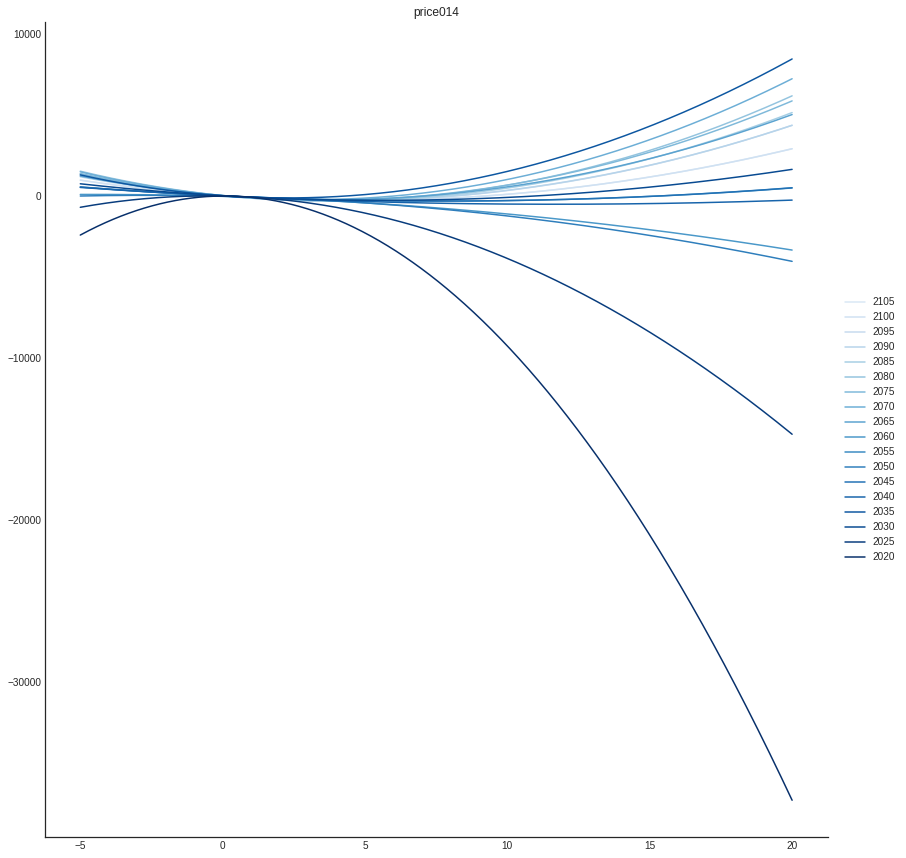

In [353]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.growth_rate)
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(coeffs_all_years.growth_rate.values):

        lines = []
        for y in reversed(coeffs_all_years.year.values[:86:5]):

            lines.append(
                axes[vi//2, vi%2].plot(
                    temps.values,
                    spaghetti.sel(year=y, growth_rate=v).values,
                    color=matplotlib.cm.Blues_r((y-2020.0)/(2100-2000)),
                    label=int(y)))

        axes[vi//2, vi%2].set_facecolor('white')
        axes[vi//2, vi%2].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    

### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2020, 2300]$$

In [354]:
damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff'))

In [355]:
damages.pulse.values

array(['rcp', 'pulse'], dtype='<U5')

### Plot time series of damages

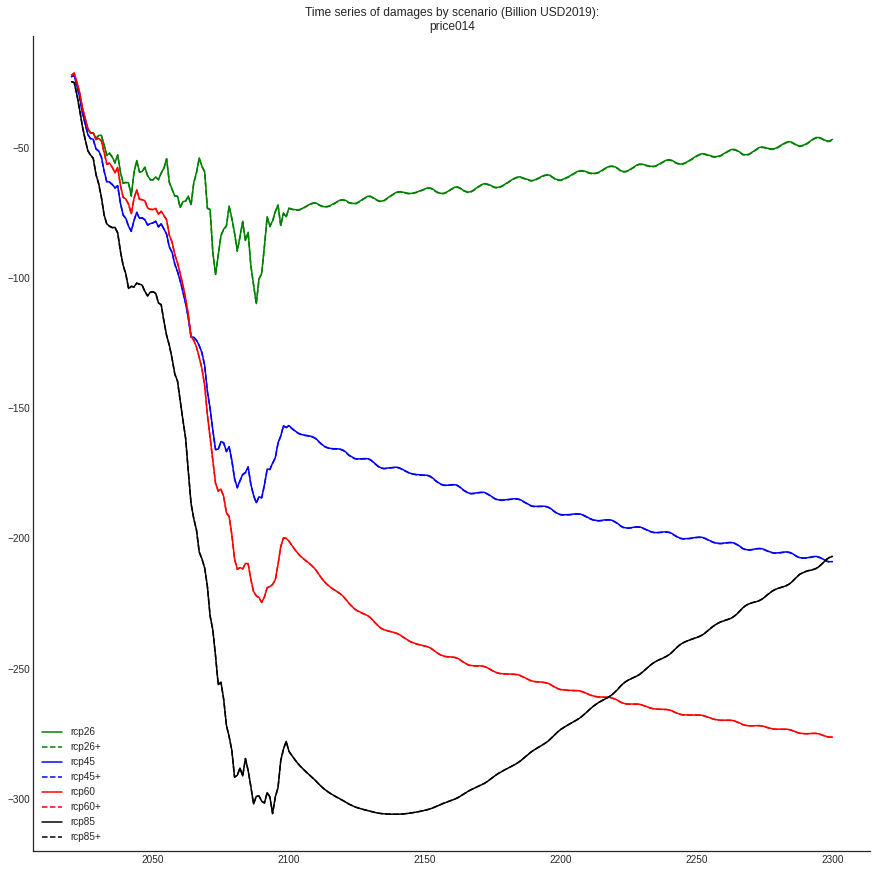

In [356]:
if generate_plots:
    numvars = len(coeffs_all_years.growth_rate)
    fig, ax = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        ax = np.array([[ax]])

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for g, gr in enumerate(damages.growth_rate.values):
        for r, rcp in enumerate(damages.rcp.values):
            for p, pulse in enumerate(damages.pulse.values):
                if(g==0):
                    labels.append('{}{}'.format(rcp, ['', '+'][p]))
                lines.append(
                    ax[g//2, g%2].plot(
                        damages.year,
                        damages.sel(growth_rate=gr, rcp=rcp, pulse=pulse),
                        color=colors[r],
                        linestyle=styles[p])[0])
        
        ax[g//2, g%2].set_title('Time series of damages by scenario (Billion USD2019):\n{}'.format(gr))
        ax[g//2, g%2].legend(lines, labels)

    sns.despine()    

### Plot time series of damages incurred due to pulse

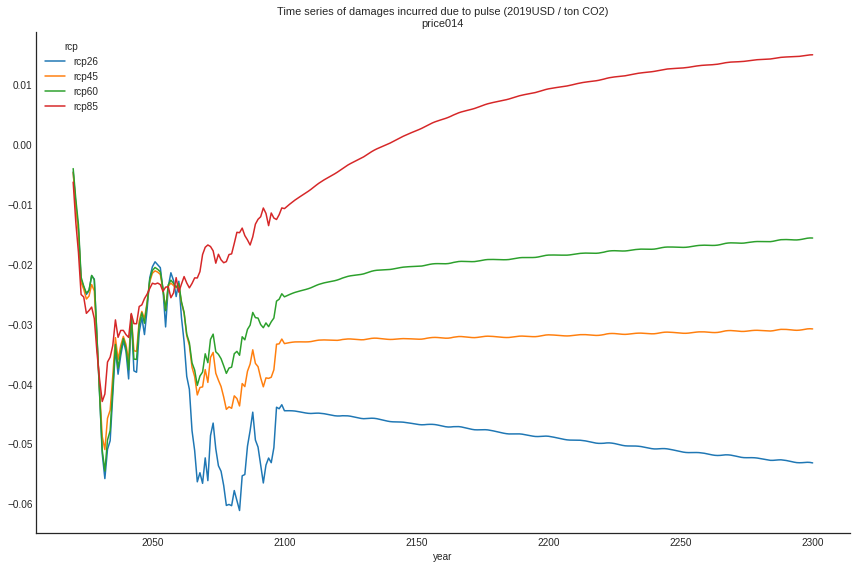

In [357]:
if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (damages.sel(growth_rate=var) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Time series of damages incurred due to pulse (2019USD / ton CO2)\n{}'.format(var),
            size=11)

    sns.despine()
    plt.tight_layout()


### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2020, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2020}}}$$

### Plot the current equivalent damage time series

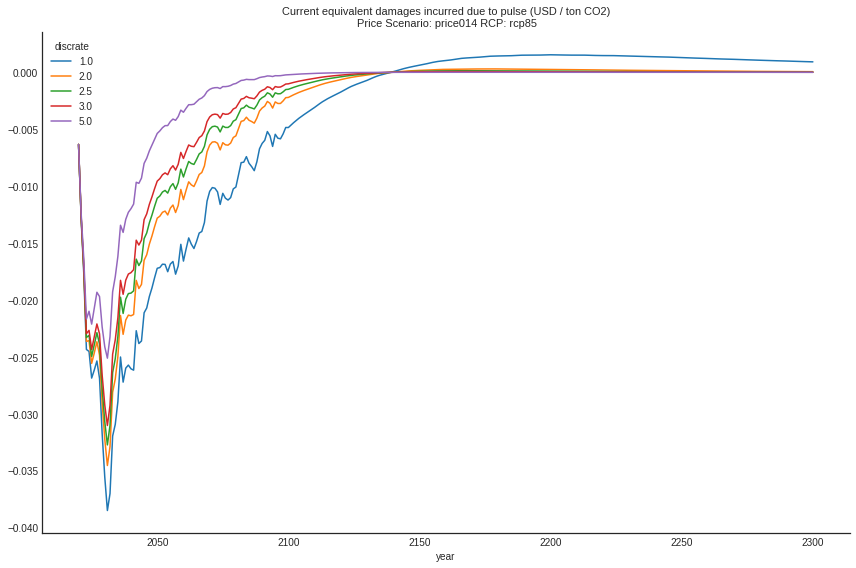

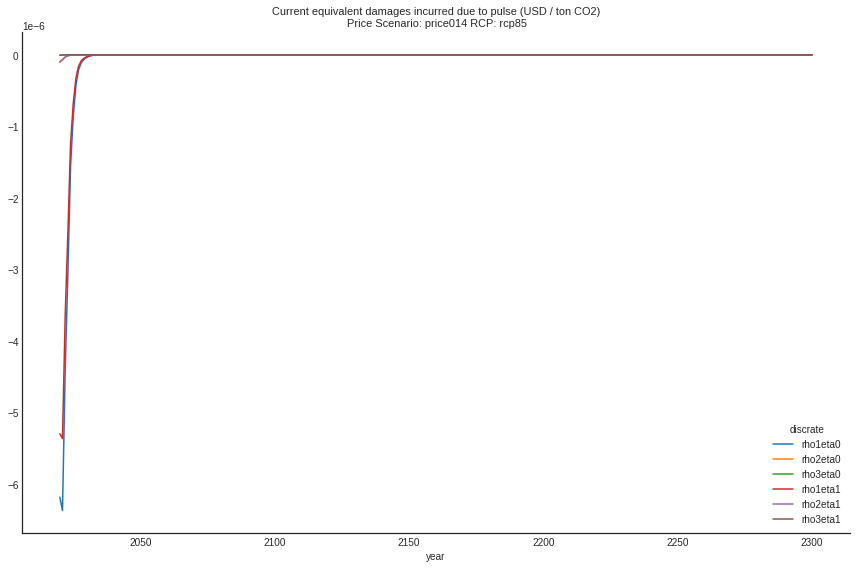

In [358]:
discrates_simple = [1.,2.,2.5, 3., 5.]


discdata = []
for r in discrates_simple:
    discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020


# if ssp == '3': # get ramsey discounting factors and put them in a structure that we can use
# discfac_ramsey_old = pd.read_csv("{}/data/discount_factors_mean_iam_per_ssp.csv".format(root))

discfac_ramsey = pd.read_csv("{}/data/discount_factors_all_ssp_rhos_etas.csv".format(root))
discfac_ramsey = discfac_ramsey.loc[(discfac_ramsey.model == "OECD Env-Growth") & (discfac_ramsey.ssp == "SSP"+ssp)] 
discfac_ramsey["discrates"] = "rho" + discfac_ramsey.rho.astype(str) + "eta" + discfac_ramsey.eta.astype(str)
discfac_ramsey = discfac_ramsey.loc[(discfac_ramsey.year >= 2020) &( discfac_ramsey.ssp == "SSP"+ssp)]
discrates_ramsey = discfac_ramsey.discrates.unique()
discfac_ramsey[stem] = discfac_ramsey.discount_factor
discfac_ramsey = discfac_ramsey[["year",stem,"discrates"]]
discfac_ramsey = discfac_ramsey.set_index(["year",'discrates']).to_xarray().to_array()

for r in discrates_ramsey:
    discdata.append((damages * discfac_ramsey.sel(discrates=r)).squeeze(
        dim = ["variable"]).drop(labels = "discrates"))


# discdata.append((damages * discfac_ramsey).squeeze(dim = "variable"))
# discrates_simple = discrates
discrates_ramsey = discrates_ramsey.tolist()
discrates = discrates_simple + discrates_ramsey

# discrates_ramsey = discrates_ramsey.tolist()


# discfac_ramsey = discfac_ramsey.loc[(discfac_ramsey.year >= 2020) &( discfac_ramsey.ssp == "SSP3")]
# discfac_ramsey[stem] = discfac_ramsey.discount_factors
# discfac_ramsey = discfac_ramsey[["year",stem]]
# discfac_ramsey = discfac_ramsey.set_index("year").to_xarray().to_array()
# discdata.append((damages * discfac_ramsey).squeeze(dim = "variable"))
# discrates.append("ramsey")

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

current_equivalent_damages_simple = current_equivalent_damages.sel(discrate = discrates_simple)
current_equivalent_damages_ramsey = current_equivalent_damages.sel(discrate = discrates_ramsey)

# current_equivalent_damages_ramsey 


rcp = 'rcp85'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages_simple.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_{}_{}_current_equivalent_damages_rcp85_simple_discrates.pdf'.format(root,ssp,hold_2100_damages_fixed, model))

    
    
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages_ramsey.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_{}_{}_current_equivalent_damages_rcp85_ramsey_discrates.pdf'.format(root,ssp,hold_2100_damages_fixed, model))

    
    


In [359]:
discrates_ramsey

['rho1eta0', 'rho2eta0', 'rho3eta0', 'rho1eta1', 'rho2eta1', 'rho3eta1']

In [360]:
# WIP: update figure 4 panel D
# discrates = [2.]

# discdata = []
# for r in discrates:
#     discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

# current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

# rcp = 'rcp45'
# if generate_plots: 
#     fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

#     if numvars == 1:
#         axes = np.array([[axes]])

#     for vi, var in enumerate(damages['growth_rate'].values):
#         (current_equivalent_damages.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
#         axes[vi//2, vi%2].axes.set_title(
#             'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
#             size=11)

#     sns.despine()
#     plt.tight_layout()
#     plt.savefig('{}/figures/SSP{}_fixed_{}_current_equivalent_damages_rcp45.pdf'.format(root,ssp,hold_2100_damages_fixed))


### Plot SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [361]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2020, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_share_post2100 = (
    scc_post_2100 / scc)

scc = xr.concat([scc, scc_pre_2100, scc_post_2100, scc_share_post2100], pd.Index(['all', 'pre2100', 'post2100', 'share_post2100'], name='time_cut'))


### Export SCC to CSV

In [362]:
 (
    scc
    .to_series()
    .unstack('rcp')
    .to_csv('{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)))

In [363]:
'{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)

'/home/liruixue/repos/energy-code-release-2020/figures/scc_values/main//scc_energy_SSP1_all_prices_2100-fixed-True.csv'

In [364]:
# Print the output to the notebook, so we can take a look in the browser.
scc.to_series().unstack('rcp')

rcp                                         rcp26         rcp45         rcp60  \
time_cut       discrate growth_rate                                             
all            1.0      price014    -3.966384e+00 -3.059231e+00 -2.490105e+00   
               2.0      price014    -1.926813e+00 -1.604297e+00 -1.440410e+00   
               2.5      price014    -1.490326e+00 -1.275618e+00 -1.179354e+00   
               3.0      price014    -1.203823e+00 -1.053772e+00 -9.948926e-01   
               5.0      price014    -6.588519e-01 -6.108196e-01 -6.003901e-01   
               rho1eta0 price014    -1.864605e-05 -1.917813e-05 -1.744273e-05   
               rho1eta1 price014    -1.547042e-05 -1.591184e-05 -1.445413e-05   
               rho2eta0 price014    -1.835257e-07 -1.886360e-07 -1.676649e-07   
               rho2eta1 price014    -1.635968e-07 -1.681474e-07 -1.493814e-07   
               rho3eta0 price014    -8.110199e-09 -8.329449e-09 -7.328839e-09   
               rho3eta1 price014    -7.460040e-09 -7.661520e-09 -6.739507e-09   
post2100       1.0      price014    -1.871063e+00 -1.271062e+00 -8.015288e-01   
               2.0      price014    -4.771517e-01 -3.335267e-01 -2.198505e-01   
               2.5      price014    -2.605626e-01 -1.839299e-01 -1.232672e-01   
               3.0      price014    -1.476482e-01 -1.050143e-01 -7.133978e-02   
               5.0      price014    -1.919756e-02 -1.389018e-02 -9.773119e-03   
               rho1eta0 price014    -7.190914e-29 -5.366265e-29 -4.086024e-29   
               rho1eta1 price014    -2.518906e-29 -1.879814e-29 -1.431453e-29   
               rho2eta0 price014    -7.648320e-45 -5.714401e-45 -4.362513e-45   
               rho2eta1 price014    -3.804420e-45 -2.842477e-45 -2.170059e-45   
               rho3eta0 price014    -3.871880e-56 -2.894042e-56 -2.211338e-56   
               rho3eta1 price014    -2.293475e-56 -1.714268e-56 -1.309884e-56   
pre2100        1.0      price014    -2.095321e+00 -1.788169e+00 -1.688577e+00   
               2.0      price014    -1.449661e+00 -1.270771e+00 -1.220559e+00   
               2.5      price014    -1.229763e+00 -1.091688e+00 -1.056087e+00   
               3.0      price014    -1.056175e+00 -9.487577e-01 -9.235528e-01   
               5.0      price014    -6.396543e-01 -5.969294e-01 -5.906170e-01   
               rho1eta0 price014    -1.864605e-05 -1.917813e-05 -1.744273e-05   
               rho1eta1 price014    -1.547042e-05 -1.591184e-05 -1.445413e-05   
               rho2eta0 price014    -1.835257e-07 -1.886360e-07 -1.676649e-07   
               rho2eta1 price014    -1.635968e-07 -1.681474e-07 -1.493814e-07   
               rho3eta0 price014    -8.110199e-09 -8.329449e-09 -7.328839e-09   
               rho3eta1 price014    -7.460040e-09 -7.661520e-09 -6.739507e-09   
share_post2100 1.0      price014     4.717302e-01  4.154840e-01  3.218855e-01   
               2.0      price014     2.476378e-01  2.078958e-01  1.526305e-01   
               2.5      price014     1.748360e-01  1.441889e-01  1.045209e-01   
               3.0      price014     1.226494e-01  9.965561e-02  7.170601e-02   
               5.0      price014     2.913790e-02  2.274024e-02  1.627795e-02   
               rho1eta0 price014     3.856535e-24  2.798117e-24  2.342537e-24   
               rho1eta1 price014     1.628208e-24  1.181393e-24  9.903419e-25   
               rho2eta0 price014     4.167439e-38  3.029327e-38  2.601924e-38   
               rho2eta1 price014     2.325486e-38  1.690468e-38  1.452697e-38   
               rho3eta0 price014     4.774088e-48  3.474470e-48  3.017310e-48   
               rho3eta1 price014     3.074347e-48  2.237504e-48  1.943590e-48   

rcp                                         rcp85  
time_cut       discrate growth_rate                
all            1.0      price014    -1.194467e+00  
               2.0      price014    -1.003742e+00  
               2.5      price014    -8.954204e-01  
             